In [4]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import datetime  # For datetime objects
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])

# Import the backtrader platform
import backtrader as bt

In [30]:
class TestStrategy(bt.Strategy):
    
    params = dict(profit_percent=0.3, loss_percent = 0.2, efast = 10, eslow=30)
    
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.price = None
        self.comm = None
        emafast = bt.ind.EMA(period=self.p.efast)
        emaslow = bt.ind.EMA(period=self.p.eslow)
        self.crossover = bt.ind.CrossOver(emafast,emaslow)
        
    def notify_order(self, order):
        date = self.data.datetime.datetime().date()
        
        if order.status in [order.Submitted, order.Accepted]:
            return
            
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.price = order.executed.price
                self.comm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Margin, order.Rejected]:
            self.log('Order Margin/Rejected')
        
        elif order.status in [order.Canceled]:
            self.log('Order Canceled')
            #Closing Bracket orders comes under this condition

        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
                 
    def next(self):
        #self.log('Close, %.2f' % self.dataclose[0])

        if self.order:
            return

        if not self.position:
            #Check the order while placing the amounts for different types, limit order and to do functions
            #like find a breakout and confirm the indicator. Many a times generates errors
            if self.crossover>0:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                entry = self.dataclose
                self.order = self.buy_bracket(limitprice=entry*(1+self.p.profit_percent),
                                              stopprice=entry*(1-self.p.loss_percent),
                                              exectype=bt.Order.Market)

        #Uncomment this and find that it is buying and selling way too frequently.
        #The behavior can be observed from the plot but no explanation
        #else:
        #    if self.crossover<0:
        #        self.log('SELL CREATE, %.2f' % self.dataclose[0])
        #        entry = self.dataclose
        #        self.order = self.sell_bracket(limitprice=entry*(1-self.p.profit_percent),
        #                                      stopprice=entry*(1+self.p.loss_percent),
        #                                      exectype=bt.Order.Market)

        

In [31]:
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    datapath = os.path.join(modpath, 'datas/orcl-1995-2014.txt')

    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname=datapath,
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values before this date
        todate=datetime.datetime(2000, 12, 31),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=10)

    # Set the commission
    cerebro.broker.setcommission(commission=0.001)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    result = cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())


Starting Portfolio Value: 100000.00
2000-05-01, BUY CREATE, 35.44
2000-05-02, BUY EXECUTED, Price: 35.11, Cost: 351.10, Comm 0.35
2000-05-04, SELL CREATE, 33.02
2000-05-05, SELL EXECUTED, Price: 32.91, Cost: 351.10, Comm 0.33
2000-05-05, OPERATION PROFIT, GROSS -22.00, NET -22.68
2000-05-05, BUY CREATE, 34.16
2000-05-08, BUY EXECUTED, Price: 33.49, Cost: 334.90, Comm 0.33
2000-05-08, SELL CREATE, 32.16
2000-05-09, SELL EXECUTED, Price: 32.77, Cost: 334.90, Comm 0.33
2000-05-09, OPERATION PROFIT, GROSS -7.20, NET -7.86
2000-05-17, BUY CREATE, 34.77
2000-05-18, BUY EXECUTED, Price: 34.83, Cost: 348.30, Comm 0.35
2000-05-18, SELL CREATE, 32.49
2000-05-19, SELL EXECUTED, Price: 32.02, Cost: 348.30, Comm 0.32
2000-05-19, OPERATION PROFIT, GROSS -28.10, NET -28.77
2000-05-22, SELL EXECUTED, Price: 28.35, Cost: -283.52, Comm 0.28
2000-05-22, Order Canceled
2000-05-23, SELL EXECUTED, Price: 27.82, Cost: -278.16, Comm 0.28
2000-05-23, Order Canceled
2000-05-24, SELL EXECUTED, Price: 27.33, Cost

<IPython.core.display.Javascript object>


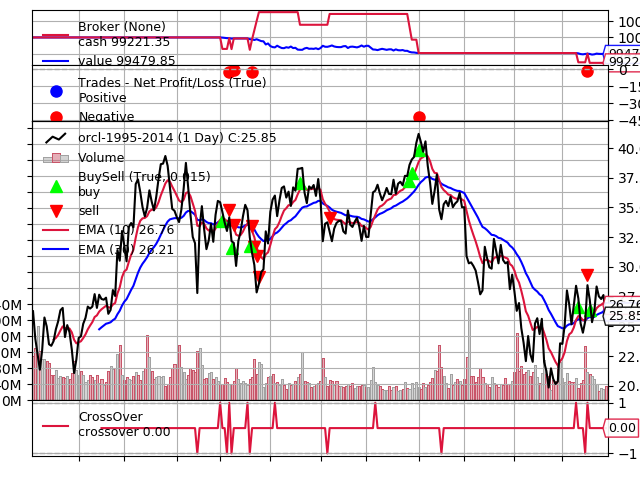

[[<Figure size 640x480 with 5 Axes>]]

In [23]:
cerebro.plot()
#Observe that a lot more green and red markers for buying and selling respectively
#Even at the points where there is no crossover whatsoever